# Introducción

En el siguiente trabajo vamos a usar los datos etiquetados y no etiquetados para elaborar clasificadores semi y no supervisados.

Primero vamos a retomar lo que hicimos en el práctico combinado de Analisis y Visualización y Curación y vamos a armar dos grafos distintos con dos criterios distintos. Uno de usuarios según los retweets y otro con un criterio elegido por ustedes.

Luego vamos a correr un algoritmo para encontrar comunidades en esos grafos. Las comunidades nos van a permitir dividir el conjunto de entrenamiento en clusters.

Una vez que tenemos las comunidades/clusters definidos, debemos asignar cada uno a una clase. Cada elemento perteneciente a una comunidad asociada a una clase será etiquetado como de esa clase. Luego usaremos esos ejemplos para entrenar nuestro clasificador.

Vamos a hacer esto para los tres tópicos: aborto, cambio climático y feminismo.

In [ ]:
import pandas as pd
# permite que una misma celda imprima varios resultados
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_rows', 20000)
pd.set_option('display.max_columns', 20000)
pd.set_option('display.max_colwidth', -1)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import json

from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

!pip install contractions
import contractions
import re
from sklearn import metrics as ms

!pip install cylouvain
import cylouvain
import time
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
abortion = pd.read_csv('/content/drive/My Drive/Tweeter/Datasets/abortion_tweets.csv', engine='python')

### Cobertura

In [ ]:
def get_text(tweet):
    if tweet["tweet.retweeted_status.text"] == tweet["tweet.retweeted_status.text"]:
        return tweet["tweet.retweeted_status.text"]
    else:
        return tweet["tweet.full_text"]

In [ ]:
def get_text2(tweet):
    if tweet["tweet.extended_tweet.full_text"] == tweet["tweet.extended_tweet.full_text"]:  
        return tweet["tweet.extended_tweet.full_text"]
    else:
        return tweet["full_text"]

In [ ]:
abortion["full_text"] = abortion.apply(get_text, axis=1)

In [ ]:
abortion["full_text2"] = abortion.apply(get_text2, axis=1)

In [ ]:
abortion["full_text2"] = abortion["full_text2"].fillna(0)
abortion['category'] = np.where(abortion.full_text2 == 0 , 0, 1)
abortion['full_text2'] = np.where(abortion['category'] == 0, abortion['tweet.text'], abortion['full_text2'])

In [ ]:
print(len(abortion["tweet.full_text"]))
print(len(abortion["full_text2"].dropna()))

## Grafo

#### De retweets

In [ ]:
retweets = abortion.dropna(subset=["tweet.retweeted_status.user.id_str"]) #Subset lo que hace es me elimina la fila si el nan está en la columna que le paso como parámetro
len(retweets["tweet.retweeted_status.user.id_str"])

In [ ]:
full_g = nx.Graph()
vertex_ids = set()


for user1, user2 in zip(retweets["tweet.user.id_str"], retweets["tweet.retweeted_status.user.id_str"]):
    full_g.add_edge(user1, user2)

In [ ]:
n = len(full_g.nodes)
m = len(full_g.edges)
complete = n * (n-1) / 2

print("Nodos: {:.0f}".format(n))
print("Ejes: {:.0f}".format(m))

In [ ]:
degrees = np.array([full_g.degree(node) for node in full_g.nodes()])

plt.hist(degrees, range=(0, 200), bins=100);
plt.semilogy();

In [ ]:
def subgraph_strong_nodes(g, n):
    """
    Devuelve subgrafo con nodos de grado mayor a n
    """
    good_nodes = [node for node in g.nodes() if g.degree(node) >= n]
    
    return g.subgraph(good_nodes)

In [ ]:
g = subgraph_strong_nodes(full_g, 5)

print("Nos quedan {:.2f}M nodos (antes eran {:.2f}M)".format(
    len(g.nodes) / 1e6,
    len(full_g.nodes) / 1e6
))
print("Componentes conexas = {}".format(len(list(nx.connected_components(g)))))

In [ ]:
components = list(nx.connected_components(g))

print("Componentes conexas = {}".format(len(components)))

print("Componente 0  --> {:<6} usuarios".format(len(components[0])))

resto = [len(components[i]) for i in range(1, len(components))]
print("Restantes     --> {:<6} usuarios".format(sum(resto)))


In [ ]:
g = g.subgraph(components[0])

#### Alternativo

In [ ]:
g2 = # TODO

SyntaxError: ignored

# Comunidades

Como método para detectar las comunidades vamos a usar el algoritmo de Louvain
https://es.wikipedia.org/wiki/M%C3%A9todo_de_Louvain

Louvain es un método iterativo que busca armar comunidades en función de maximizar la modularidad. A grandes rasgos, arma comunidades tales que hagan que la mayor cantidad de aristas conecten dos nodos que sean de la misma comunidad. El problema es que la solución ideal a esta modularidad es muy costosa computacionalmente. Por lo tanto, Louvain es una heurística iterativa (en cada iteración se acerca un poco más a una solución mejor sin necesariamente llegar a alcanzar una solución ideal). Al ser un método iterativo no es exacto: correrlo varias veces con los mismos parámetros puede dar distintos resultados. El algoritmo termina cuando logra estabilidad, es decir, un valor de modularidad que considera aceptable.

Nosotros vamos a trabajar con un parámetro específico de este algoritmo que es la resolución. La resolución afecta la estabilidad del sistema: a mayor resolución, se necesitan más iteraciones para lograr estabilidad. En particular, lo que a nosotros nos interesa, es que **a mayor resolución, el algoritmo encuentra menos comunidades de mayor tamaño** (se polariza).

Lo que nosotros queremos hacer es encontrar el menor valor de la resolución que nos de como resultado únicamente  dos comunidades polares que tengan más de una cierta cantidad de usuarios (definida en la variable users_threshold)

In [ ]:
# https://pypi.org/project/cylouvain/


# Devuelve todas las particiones según la resolución. Si hay una particion ideal
# (la menor particion que genere 2 o menos comunidades), la devuelve. Sino devuelve -1
def findPartitions(g, user_threshold, resolutions):
    resolutions.sort()
    best_resolution = -1
    found_best = False
    partitions = {}
    for resolution in resolutions:
        print("resolución {:.2f}".format(resolution), end="")

        partition = cylouvain.best_partition(g, resolution=resolution)

        num_partitions = len(set(partition.values()))
        counter = Counter(partition.values())

        # Aca le está diciendo que cuente cuantas son las que tienen usuarios mayores al threshold
        important_partitions = len([_ for x in counter.items() if x[1] > user_threshold])


        if important_partitions <= 2 and not found_best: #para mi acá va mayor o igual porque sino la resolution abajo siempre nos da 1
            best_resolution = resolution
            found_best = True
            
        print("---> {} particiones ({} con más de {} usuarios)".format(
            num_partitions,
            important_partitions,
            user_threshold,
        ))
        #print("Tiempo: {:.2f} minutos".format((end - begin) / 60))
        partitions[resolution] = partition
    return partitions, best_resolution

In [ ]:
# Ejemplo
partitions, resolution = findPartitions(g, 1000,  [1.0, 1.5, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])

In [ ]:
resolution

3.0

In [ ]:
# Aca paso del formato lista de tupla<nodo, Número de comunidad> a un mapa que para cada comunidad tiene la lista de los nodos que pertenecen
if resolution != -1:
    partition = partitions[resolution] #acá no debería ir la mejor resolución que tiró la función de arriba? Como está el código, acá siempre da 1
    partition_to_ids = {partition_number:[] for partition_number in range(len(set(partition.values())))}

    num_partitions = len(set(partition.values()))
    for user_id, user_partition in partition.items():
        partition_to_ids[user_partition].append(user_id)
else:
    print("Hay más de dos particiones principales")
    


In [ ]:
Counter(partition.values())

Counter({0: 182, 1: 12946, 2: 4935, 3: 129, 4: 17, 5: 713})

### Ejercicio 1

Prueben distintos valores de user_threshold y distintas resoluciones evaluando cosas como cuantos (y cuales) nodos del grafo (sean los nodos usuarios u otra cosa) les quedan por fuera de las dos comunidades más grandes (no necesariamente es malo que queden muchos nodos afuera si verdaderamente no tienen una postura clara sobre el tópico); que proporcion tienen esas dos comunidades más grandes: ¿son parejas entre sí o no?; en el caso de que los nodos sean usuarios, además de los usuarios, ¿son parejas la cantidad de tweets que postean esos usuarios? ¿Cuántos tweets hay de cada comunidad?

**Respuesta:** Probamos con diferentes user_threshold y diferentes resoluciones, y obtuvimos que con una resolucion 3 y user_threshold 1000, obtenemos 2 comunidades grandes. Abarcando una proporción del 94%. (68% y 26% respectivamente).
No es pareja la cantidad de nodos asi como tampoco es pareja la cantidad de tweets.

En el Data Frame "com" se pueden observar las cantidades y proporciones de tweets por comunidad y usuario.

In [ ]:
partitions, resolution = findPartitions(g, 1000,  [1.0, 1.5, 2.0, 3.0, 5.0, 6.0, 7.0, 10.0, 15.0, 20.0, 25.0])

resolución 1.00---> 29 particiones (4 con más de 1000 usuarios)
resolución 1.50---> 12 particiones (4 con más de 1000 usuarios)
resolución 2.00---> 11 particiones (3 con más de 1000 usuarios)
resolución 3.00---> 6 particiones (2 con más de 1000 usuarios)
resolución 5.00---> 5 particiones (2 con más de 1000 usuarios)
resolución 6.00---> 5 particiones (2 con más de 1000 usuarios)
resolución 7.00---> 5 particiones (2 con más de 1000 usuarios)
resolución 10.00---> 3 particiones (2 con más de 1000 usuarios)
resolución 15.00---> 3 particiones (2 con más de 1000 usuarios)
resolución 20.00---> 3 particiones (2 con más de 1000 usuarios)
resolución 25.00---> 3 particiones (2 con más de 1000 usuarios)


In [ ]:
resolution

3.0

In [ ]:
# Aca paso del formato lista de tupla<nodo, Número de comunidad> a un mapa que para cada comunidad tiene la lista de los nodos que pertenecen
if resolution != -1:
    partition = partitions[resolution]
    partition_to_ids = {partition_number:[] for partition_number in range(len(set(partition.values())))}

    num_partitions = len(set(partition.values()))
    for user_id, user_partition in partition.items():
        partition_to_ids[user_partition].append(user_id)
else:
    print("Hay más de dos particiones principales")
  

Cantidad de Usuarios y cantidad de Tweets por partición.

Partition 1 y 2 son las comunidades mas grandes.

In [ ]:
comunidad, tweets, comunidades, tweet_comunidad = {}, {}, {}, {}
for i in range(len(set(partition.values()))):
  comunidad[i] = partition_to_ids[i]
  tweet_comunidad[i] = retweets[retweets['tweet.user.id_str'].isin(comunidad[i])]
  comunidades[i] = len(comunidad[i])
  tweets[i] = len(tweet_comunidad[i])

com = pd.DataFrame({'users': comunidades, 'tweets': tweets}) 

In [ ]:
com['tweets por usuario'] = com['tweets'] / com['users'] 
com

,users,tweets,tweets por usuario
0,182,854,4.692308
1,12946,135946,10.501004
2,4935,31740,6.431611
3,129,810,6.279070
4,17,54,3.176471
5,713,4883,6.848527


Proporción comunidades mas grandes sobre el total

In [ ]:
com.iloc[1:3]['users'].sum() / com['users'].sum()

0.9449846739245323

### Esto es para ver qué hay en los tweets que quedan fuera de las comunidades más grandes

In [ ]:
Counter(partition.values())

Counter({0: 182, 1: 12946, 2: 4935, 3: 129, 4: 17, 5: 713})

In [ ]:
users_out = [key  for (key, value) in partition.items() if value ==0]

In [ ]:
retweets[retweets['tweet.user.id_str'].isin(users_out)]['full_text2'].head(20)


813      Polska górą! Wojciech Cejrowski @TheCejrowski zaprasza na film:\n#Nieplanowane #Unplanned !\nSzczególnie polecam dla:… https://t.co/6aXwb89cIg  
2339     #Nieplanowane "To jest film opowiedziany oczami aborcjonistki, która odchodzi z organizacji, jaką jest Planned Pare… https://t.co/v7EPHsb0ed    
2933     Rząd Prawa i Sprawiedliwości oszukał katolików: w 2015 roku obiecali nam pełną ochronę życia od poczęcia. Aborcja e… https://t.co/y5hAM4lcy3    
2982     Trybunał Konstytucyjny przejęty przez Prawo i Sprawiedliwość zablokował pełną ochronę życia w minionej kadencji, w… https://t.co/UMt2APexhT     
3014     #Nieplanowane "To jest film opowiedziany oczami aborcjonistki, która odchodzi z organizacji, jaką jest Planned Pare… https://t.co/v7EPHsb0ed    
3688     RT @True_Poland: Katolicka partia Prawo i Sprawiedliwość!? #StrzeżcieSię tych co mówią o ochronie rodziny, zapewniają o jej dobru a są winn…    
4440     RT @True_Poland: Pani @KrystPawlowicz wszyscy się cieszymy, że Prof

### Ejercicio 2

Armen un script que para cada comunidad muestre datos que permitan evaluar cuan bien se ajusta a la clase a la que la queremos asignar. Algunos ejemplos pueden ser: usuarios con más cantidad de retweets, tweets más retwiteados, tweets de los usuarios con más cantidad de tweets, etc. Tiene que ser algo que de un panorama de qué es esa comunidad pero a su vez sencillo de ver y que convenza a alguien que lo ve desde afuera que usar esas comunidades puede servir.

#### Decidimos ver algunos tweets de los usuarios con mas tweets de cada comunidad. Con lo que podemos concluir que la Comunidad 1 es la que está en contra y la comunidad 2 es la que esta a favor de la legalización del Aborto.

In [ ]:
df_comunidad1 = tweet_comunidad[1] #En contra
df_comunidad2 = tweet_comunidad[2] #A favor

In [ ]:
df_comunidad1.shape, df_comunidad2.shape

((135946, 43), (31740, 43))

Generamos una lista con los 10 usuarios mas tweeteadores de la Comunidad 1 

(135946 tweets)

In [ ]:
list_influencers = df_comunidad1.groupby(by='tweet.user.id_str').count().sort_values(by='query', ascending=False).iloc[:10]

In [ ]:
list_influencers = list_influencers.iloc[:,:0].reset_index()

### Ejemplos de tweets de uno de los usuarios con mas tweets indican que la comunidad 1 estan **En contra de la legalización del Aborto**. 

    -A just and loving society protects its most vulnerable members.
    -I march to give a voice to those who will never have one. I march to show people that there are people out there that…
    -#40DaysForLife has come to an end, and 454 unique, irreplaceable babies have been saved from abortion thanks to the

In [ ]:
np.random.seed(33)
retweets[retweets['tweet.user.id_str'] == list_influencers['tweet.user.id_str'][3]].sample(4)

,_id,query,tweet.created_at,tweet.id_str,tweet.full_text,tweet.text,tweet.extended_tweet.full_text,tweet.display_text_range,tweet.entities,tweet.user.id_str,tweet.user.name,tweet.user.screen_name,tweet.user.location,tweet.user.verified,tweet.user.followers_count,tweet.user.friends_count,tweet.user.listed_count,tweet.user.favorites_count,tweet.user.statuses_count,tweet.user.created_at,tweet.user.following,tweet.retweet_status,tweet.retweeted_status.created_at,tweet.retweeted_status.id_str,tweet.retweeted_status.text,tweet.retweeted_status.user.id_str,tweet.retweeted_status.user.name,tweet.retweeted_status.user.screen_name,tweet.retweeted_status.user.location,tweet.retweeted_status.user.verified,tweet.retweeted_status.user.followers_count,tweet.retweeted_status.user.friends_count,tweet.retweeted_status.user.listed_count,tweet.retweeted_status.user.favorites_count,tweet.retweeted_status.user.statuses_count,tweet.retweeted_status.user.created_at,tweet.retweeted_status.user.id_str.1,tweet.retweeted_status.user.following,tweet.retweeted_status.retweet_status,tweet.retweeted_status.extended_tweet,full_text,full_text2,category
578450,ObjectId(5dcdb022ee0a4baf1b053ee2),pro-choice,Mon Nov 11 00:35:11 +0000 2019,1193688588271136768,RT @wendirby671: @TheModernFinn @LiveAction A fact that will be ignored by the Pro-Choice advocates.,NaN,NaN,"[0,100]","{""hashtags"":[],""symbols"":[],""user_mentions"":[{""screen_name"":""wendirby671"",""name"":""wendirby67"",""id"":{""$numberLong"":""954192865458098178""},""id_str"":""954192865458098178"",""indices"":[3,15]},{""screen_name"":""TheModernFinn"",""name"":""Zorba the Great"",""id"":{""$numberLong"":""2254511168""},""id_str"":""2254511168"",""indices"":[17,31]},{""screen_name"":""LiveAction"",""name"":""Live Action"",""id"":18001922,""id_str"":""18001922"",""indices"":[32,43]}],""urls"":[]}",2846112553,Lia Pimenov,pimenov_lia,California,False,2119,198,98,NaN,399325,Wed Oct 08 04:24:10 +0000 2014,False,NaN,Sun Nov 10 23:06:30 +0000 2019,1.193666e+18,NaN,9.541929e+17,wendirby67,wendirby671,"Virginia, USA",False,951.0,1478.0,0.0,NaN,4308.0,Fri Jan 19 03:24:41 +0000 2018,9.541929e+17,False,NaN,NaN,RT @wendirby671: @TheModernFinn @LiveAction A fact that will be ignored by the Pro-Choice advocates.,RT @wendirby671: @TheModernFinn @LiveAction A fact that will be ignored by the Pro-Choice advocates.,1
213106,ObjectId(5dc2e30ce36ea093ac6d5f44),prolife,Fri Nov 01 18:57:23 +0000 2019,1190342087964872704,RT @March_for_Life: A just and loving society protects its most vulnerable members. #prolife #whywemarch https://t.co/ZHG9NU4PIt,NaN,NaN,"[0,128]","{""hashtags"":[{""text"":""prolife"",""indices"":[84,92]},{""text"":""whywemarch"",""indices"":[93,104]}],""symbols"":[],""user_mentions"":[{""screen_name"":""March_for_Life"",""name"":""March for Life"",""id"":430130014,""id_str"":""430130014"",""indices"":[3,18]}],""urls"":[],""media"":[{""id"":{""$numberLong"":""1190317583129550849""},""id_str"":""1190317583129550849"",""indices"":[105,128],""media_url"":""http://pbs.twimg.com/media/EITbiQhWoAEQcNJ.jpg"",""media_url_https"":""https://pbs.twimg.com/media/EITbiQhWoAEQcNJ.jpg"",""url"":""https://t.co/ZHG9NU4PIt"",""display_url"":""pic.twitter.com/ZHG9NU4PIt"",""expanded_url"":""https://twitter.com/March_for_Life/status/1190317585503588354/photo/1"",""type"":""photo"",""sizes"":{""thumb"":{""w"":150,""h"":150,""resize"":""crop""},""large"":{""w"":1190,""h"":792,""resize"":""fit""},""medium"":{""w"":1190,""h"":792,""resize"":""fit""},""small"":{""w"":680,""h"":453,""resize"":""fit""}},""source_status_id"":{""$numberLong"":""1190317585503588354""},""source_status_id_str"":""1190317585503588354"",""source_user_id"":430130014,""source_user_id_str"":""430130014""}]}",2846112553,Lia Pimenov,pimenov_lia,California,False,2109,199,98,NaN,399405,Wed Oct 08 04:24:10 +0000 2014,False,NaN,Fri Nov 01 17:20:02 +0000 2019,1.190318e+18,NaN,4.301300e+08,March for Life,March_for_Life,"Washington, DC",True,107762.0,2408.0,592.0,NaN,

### Comunidad 2

In [ ]:
list_influencers2 = df_comunidad2.groupby(by='tweet.user.id_str').count().sort_values(by='query', ascending=False).iloc[:10]
list_influencers2 = list_influencers2.iloc[:,:1].reset_index()

In [ ]:
list_influencers2

,tweet.user.id_str,_id
0,1146932487215550464,255
1,1375670666,148
2,903753097457127425,134
3,1566650000,118
4,756886303300616192,110
5,1049470998490185729,99
6,20575777,95
7,43998427,81
8,1181104359586664450,75
9,275714700,75


### Ejemplos de tweets de uno de los usuarios con mas tweets indican que la comunidad 2 esta **A Favor de la legalización del Aborto**. 

    -Abortion is a common, safe and normal form of healthcare
    -ABORTION IS LEGAL IN KENTUCKY AND IT WILL STAY LEGAL IN KENTUCKY

In [ ]:
np.random.seed(40)
retweets[retweets['tweet.user.id_str'] == list_influencers2['tweet.user.id_str'][1]].sample(5)

,_id,query,tweet.created_at,tweet.id_str,tweet.full_text,tweet.text,tweet.extended_tweet.full_text,tweet.display_text_range,tweet.entities,tweet.user.id_str,tweet.user.name,tweet.user.screen_name,tweet.user.location,tweet.user.verified,tweet.user.followers_count,tweet.user.friends_count,tweet.user.listed_count,tweet.user.favorites_count,tweet.user.statuses_count,tweet.user.created_at,tweet.user.following,tweet.retweet_status,tweet.retweeted_status.created_at,tweet.retweeted_status.id_str,tweet.retweeted_status.text,tweet.retweeted_status.user.id_str,tweet.retweeted_status.user.name,tweet.retweeted_status.user.screen_name,tweet.retweeted_status.user.location,tweet.retweeted_status.user.verified,tweet.retweeted_status.user.followers_count,tweet.retweeted_status.user.friends_count,tweet.retweeted_status.user.listed_count,tweet.retweeted_status.user.favorites_count,tweet.retweeted_status.user.statuses_count,tweet.retweeted_status.user.created_at,tweet.retweeted_status.user.id_str.1,tweet.retweeted_status.user.following,tweet.retweeted_status.retweet_status,tweet.retweeted_status.extended_tweet,full_text,full_text2,category
174131,ObjectId(5dc25068e36ea093ac6be8ee),streaming,Wed Nov 06 04:47:31 +0000 2019,1191940148461801474,NaN,RT @laurenarankin: ABORTION IS LEGAL IN KENTUCKY AND IT WILL STAY LEGAL IN KENTUCKY. EMW WOMEN’S SURGICAL CENTER PROVIDES SAFE ABORTION CAR…,NaN,NaN,"{""hashtags"":[],""urls"":[],""user_mentions"":[{""screen_name"":""laurenarankin"",""name"":""Lauren Rankin"",""id"":400479746,""id_str"":""400479746"",""indices"":[3,17]}],""symbols"":[]}",1375670666,💖,helmsinki,"St Louis, MO",False,1904,4705,49,NaN,97803,Tue Apr 23 23:04:20 +0000 2013,NaN,NaN,Wed Nov 06 02:21:22 +0000 2019,1.191903e+18,ABORTION IS LEGAL IN KENTUCKY AND IT WILL STAY LEGAL IN KENTUCKY. EMW WOMEN’S SURGICAL CENTER PROVIDES SAFE ABORTIO… https://t.co/1zub5hhOcU,4.004797e+08,Lauren Rankin,laurenarankin,"Brooklyn, NY",True,18194.0,835.0,402.0,NaN,16323.0,Sat Oct 29 03:15:24 +0000 2011,4.004797e+08,NaN,NaN,"{""full_text"":""ABORTION IS LEGAL IN KENTUCKY AND IT WILL STAY LEGAL IN KENTUCKY. EMW WOMEN’S SURGICAL CENTER PROVIDES SAFE ABORTION CARE IN KENTUCKY AND IT WILL CONTINUE PROVIDING SAFE ABORTION CARE IN KENTUCKY. 🙌 https://t.co/6GXnssDOXR"",""display_text_range"":[0,198],""entities"":{""hashtags"":[],""urls"":[{""url"":""https://t.co/6GXnssDOXR"",""expanded_url"":""https://twitter.com/evan_rosenfeld/status/1191902807936253952"",""display_url"":""twitter.com/evan_rosenfeld…"",""indices"":[199,222]}],""user_mentions"":[],""symbols"":[]}}",ABORTION IS LEGAL IN KENTUCKY AND IT WILL STAY LEGAL IN KENTUCKY. EMW WOMEN’S SURGICAL CENTER PROVIDES SAFE ABORTIO… https://t.co/1zub5hhOcU,ABORTION IS LEGAL IN KENTUCKY AND IT WILL STAY LEGAL IN KENTUCKY. EMW WOMEN’S SURGICAL CENTER PROVIDES SAFE ABORTIO… https://t.co/1zub5hhOcU,1
237184,ObjectId(5dc31e4fe36ea093ac6e3baa),streaming,Wed Nov 06 19:26:01 +0000 2019,1192161233358729222,NaN,RT @URGE_org: Calling all Ohio folks!📢Today the OH Senate is positioned to vote &amp; pass 2 anti-abortion bills: SB 208 &amp; SB 155. These bills…,NaN,NaN,"{""hashtags"":[],""urls"":[],""user_mentions"":[{""screen_name"":""URGE_org"",""name"":""URGE"",""id"":16210522,""id_str"":""16210522"",""indices"":[3,12]}],""symbols"":[]}",1375670666,💖,helmsinki,"St Louis, MO",False,1905,4706,49,NaN,97857,Tue Apr 23 23:04:20 +0000 2013,NaN,NaN,Wed Nov 06 15:01:17 +0000 2019,1.192095e+18,Calling all Ohio folks!📢Today the OH Senate is positioned to vote &amp; pass 2 anti-abortion bills: SB 208 &amp; SB 155. Th… https://t.co/M63Z8yORzT,1.621052e+07,URGE,URGE_org,USA,False,16491.0,2335.0,498.0,NaN,14331.0,Tue Sep 09 20:17:56 +0000 2008,1.621052e+07,NaN,NaN,"{""full_text"":""Calling all Ohio folks!📢Today the OH Senate is positioned to vote \u0026amp; pass 2 anti-abortion bills: SB 208 \u0026amp; SB 155. These bills are based on lies, shame \u0026amp; stigma. Contact ur senator today \u0026amp; demand they vote NO❌on these harmful bills! #StopTh

### Ejercicio 3

Hagan una nube de palabras con los tweets de cada comunidad y analicen cuan fácil o difícil es inferir la clase de esa comunidad mirando la nube.

In [ ]:
def preprocesar(text, keep_hashtags=True, remove_numbers=True):
    
    text = contractions.fix(text) 
    
    toks = tokenizer.tokenize(text)
    
    ret = []
    for tok in toks:
                
        if re.match('https?://[A-Za-z0-9./]+',tok):
            continue

        if re.match('[A-Za-z0-9./]+@[A-Za-z0-9./]+',tok):
            continue
            
        if re.match(r'[^\w\s\#,]',tok): #emoji
            continue
            
        if re.match('[^?!.,]*[?.!,]$',tok): #puntuaciones
            continue
        
        if re.match('rt',tok): #puntuaciones
            continue
        
        if re.match('abortion',tok): #puntuaciones
            continue

        if tok.isnumeric() and remove_numbers:
            continue
        ret.append(tok)
    return " ".join(ret)

In [ ]:

from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
df_comunidad1["full_text2"] = df_comunidad1["full_text2"].apply(lambda x: preprocesar(x))
df_comunidad2["full_text2"] = df_comunidad2["full_text2"].apply(lambda x: preprocesar(x))

In [ ]:
#desvectorizar
def desvectorizar(lista, dictionary) :
  result = []
  for tweet in lista :
    i = 0
    #print("Lista " +str(tweet))
    for palabra in tweet :
      if palabra > 0 :
        for y in range(palabra):
          result.append(dictionary[i])
      i = i+1
  
  #print("Resultado: "+str(result))
  return result

In [ ]:
def get_feature_names(input_retweets):
    text = input_retweets["full_text2"]

    vectorizer = CountVectorizer(
        binary=False, min_df=0.02, max_df=0.7, ngram_range=(1, 1),
        #stop_words=stopwords.words('spanish')
    )
    X_result = vectorizer.fit_transform([*text])

    return X_result, vectorizer.get_feature_names()

In [ ]:
#Comunidad 1
VEC_BOW_1, diccionario_abortion_1 = get_feature_names(df_comunidad1)
bag_of_words_abortion_1 = desvectorizar(VEC_BOW_1.toarray(), diccionario_abortion_1)
allcomments_1 = " ".join(bag_of_words_abortion_1)

#Comunidad 2
VEC_BOW_2, diccionario_abortion_2 = get_feature_names(df_comunidad2)
bag_of_words_abortion_2 = desvectorizar(VEC_BOW_2.toarray(), diccionario_abortion_2)
allcomments_2 = " ".join(bag_of_words_abortion_2)

##BOW Comunidad 1 (En contra de la legalización del Aborto)

En la nube de palabras se pueden apreciar términos que sugieren una postura en contra de la legalización del aborto:
- adoption
- prolife
- babies

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'All Tweets Wordcount')

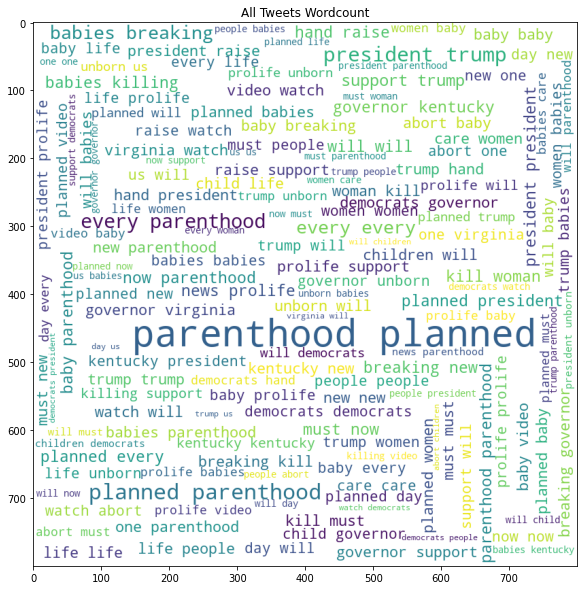

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
wordcloud1 = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = STOPWORDS,
                    min_font_size = 12).generate(allcomments_1)

# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud1)
plt.title("All Tweets Wordcount")
plt.show()

##BOW Comunidad 2 (A favor de la legalización del Aborto)

En la nube de palabras se pueden apreciar términos que sugieren una postura a favor de la legalización del aborto:
-  reproductive right
- will sound women
- care health
- choice

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'All Tweets Wordcount')

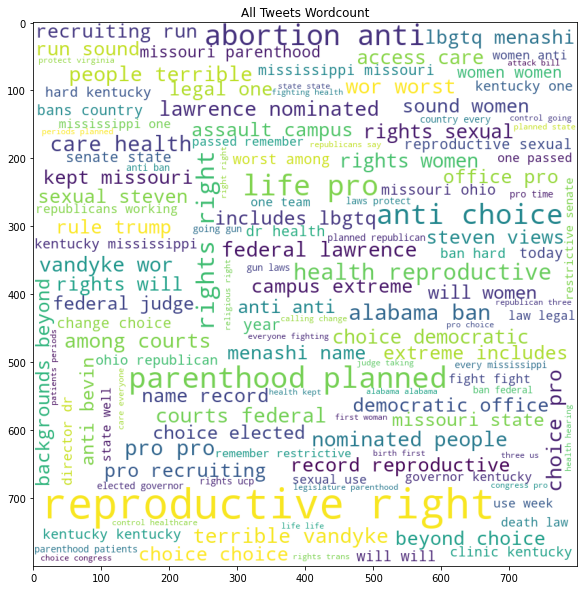

In [ ]:
wordcloud2 = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = STOPWORDS,
                    min_font_size = 12).generate(allcomments_2)

# plot the WordCloud image             
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud2)
plt.title("All Tweets Wordcount")
plt.show()

### Ejercicio 4

Decidan una clase para cada comunidad. Justifiquen su decisión planteando cuán ajustada les parece que es la asignación en función de los ejercicios anteriores

Decidimos que la comunidad 1 está en contra de la legalización del aborto y que la comunidad 2 está a favor de la legalización del aborto. La elección estuvo guiada por la exploración de algunos tweets y las palabras más importantes del BOW. 

### Ejercicio 5

Hacer los ejercicios anteriores para los tres tópicos y comparar los resultados entre sí: ¿hay tópicos para los cuales las comunidades reflejan mejor o peor la polaridad respecto al posicionamiento? ¿Por qué les parece que esto sucede así?

De los 3 tópicos, el de feminismo es el que peor refleja la polaridad respecto al posicionamiento. 

# Ejercicio 6

Generar un dataset con todos los tweets asociados a cada comunidad, cada uno etiquetado según la comunidad a la que pertenece. Usar esos datasets como entrenamiento de algun clasificador basado en alguno de los tres algoritmos que vieron en el práctico pasado: SVM's, Random Forests o Red Neuronal. Reportar las mismas métricas (Accuracy, F1 micro, macro y average)

In [ ]:
# Generar Dataset con los tweets de comunidad 1 (en contra) y comunidad 2 (a favor), generar una columna nueva STANCE con valores FAVOR y AGAINST
df_comunidad1['Stance'] = 'AGAINST'
df_comunidad2['Stance'] = 'FAVOR'

In [ ]:
df_comunidades_train = pd.concat([df_comunidad1, df_comunidad2])

In [ ]:
df_comunidades_train.groupby(by='Stance').count()['full_text2']

Stance
AGAINST    135946
FAVOR      31740 
Name: full_text2, dtype: int64

In [ ]:
df_comunidades_train = df_comunidades_train.loc[:,['full_text2', 'Stance']]

In [ ]:
np.random.seed(33)
df_comunidades_train.sample(4)

,full_text2,Stance
5608,rt this administration is coming for women's reproductive rights un ambassador kelly craft objects to mention of sexua,FAVOR
170354,wtf how did this guy get elected how andy beshear who fundraised with abortionist defeats pro-life ke,AGAINST
520042,rt tonight there was an earthquake in s own backyard matt bevin who defined himself as an anti-choice a,FAVOR
155322,kentucky has one abortion clinic left and it s been on the verge of closure a handful of times because its outgoing,FAVOR


Renombramos columna full_text2 por Tweet

In [ ]:
df_comunidades_train = df_comunidades_train.rename(columns={'full_text2':'Tweet'})
df_comunidades_train.columns

Index(['Tweet', 'Stance'], dtype='object')

Separamos set de datos en Train y Test

In [ ]:
from sklearn.model_selection import train_test_split

train_abortion_com, test_abortion_com = train_test_split(
    df_comunidades_train, 
    test_size=0.3, 
    random_state=21
)

# # tomamos solo el 30% de los datos que tenemos. 
# train_abortion_com, test_abortion_com = train_test_split(
#     train_abortion_com, 
#     test_size=0.3, 
#     random_state=21
# )

y_test_com = test_abortion_com["Stance"]
y_train_com = train_abortion_com["Stance"]

In [ ]:
len(train_abortion_com), len(test_abortion_com)

(117380, 50306)

### Cargamos Dataset de datos etiquetados (train y test) y los combinamos para tener mas datos de Test. Dado que todos estos datos seran solo para testear. 

In [ ]:
train_etiquetados = pd.read_csv('/content/drive/My Drive/Tweeter/Datasets/train.csv', engine='python')
test_etiquetados = pd.read_csv('/content/drive/My Drive/Tweeter/Datasets/test.csv', engine='python')

In [ ]:
df_etiquetados = pd.concat([train_etiquetados, test_etiquetados])

In [ ]:
df_etiquetados = df_etiquetados[df_etiquetados["Target"] == "Legalization of Abortion"]

Eliminamos las columnas que no se utilizan y las filas etiquetadas como NONE.

In [ ]:
df_etiquetados.drop(columns = ["Target", "Opinion Towards", "Sentiment"], inplace=True)

In [ ]:
df_etiquetados = df_etiquetados.drop(df_etiquetados[df_etiquetados['Stance']=='NONE'].index)

In [ ]:
df_etiquetados[df_etiquetados['Stance']=='NONE']

,Tweet,Stance


In [ ]:
df_etiquetados.head(3)

,Tweet,Stance
50,Just laid down the law on abortion in my bioethics class. #Catholic,AGAINST
51,@tooprettyclub Are you OK with #GOP males telling you what you can and can't do with your own body?,FAVOR
52,"If you don't want your kid, put it up for adoption. #sorrynotsorry",AGAINST


### Representamos como Vector el nuevo Dataset generado (etiquetado automaticamente) y el dataset etiquetado dado previamente.


In [ ]:
def dataset_vectorizer(input_train, input_validation, input_test):
    text_train = input_train["Tweet"]
    text_validation = input_validation["Tweet"]
    text_test = input_test["Tweet"]

    vectorizer = CountVectorizer(
        binary=True, min_df=0.004, max_df=0.7, ngram_range=(1, 3)
    )

    X_result = vectorizer.fit_transform([*text_train, *text_validation, *text_test])

    VEC_train = X_result[:len(text_train)]
    VEC_validation = X_result[len(text_train):-len(text_test)]
    VEC_test = X_result[-len(text_test):]
    
    return VEC_train, VEC_validation, VEC_test

In [ ]:
VEC_train_abortion, VEC_test_abortion, VEC_etiquetados = dataset_vectorizer(train_abortion_com, test_abortion_com, df_etiquetados)

In [ ]:
y_etiquetados = df_etiquetados['Stance']

In [ ]:
VEC_train_abortion.shape, y_train_com.shape, VEC_test_abortion.shape, y_test_com.shape, VEC_etiquetados.shape, y_etiquetados.shape

((117380, 1410), (117380,), (50306, 1410), (50306,), (711, 1410), (711,))

*Ya* tenemos los datos necesarios para entrenar nuestro modelo y realizar las predicciones. 

SVM

### SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
model = SVC()
model.fit(VEC_train_abortion, y_train_com)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred_test =  model.predict(VEC_test_abortion)
accuracy_test = accuracy_score(y_test_com, y_pred_test)
f1_test_micro = f1_score(y_test_com, y_pred_test, average="micro", labels=["AGAINST", "FAVOR"])
f1_test_macro = f1_score(y_test_com, y_pred_test, average="macro", labels=["AGAINST", "FAVOR"])
f1_test = f1_score(y_test_com, y_pred_test, average=None, labels=["AGAINST", "FAVOR"])
# f1_test_average = #TODO
f1_test_average = (f1_test[0] + f1_test[1]) / 2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

Accuracy para conjunto de test: 0.97
F1 micro para conjunto de test: 0.97
F1 macro para conjunto de test: 0.95
F1 average para conjunto de test: 0.95


# Ejercicio 7

Para uno de los tres tópicos, exploren un enfoque mixto supervisado/semi-supervisado. El enfoque mixto puede ser: o bien un Voting Classifier con dos clasificadores que usen el corpus supervisado y uno basado en comunidades (o uno y dos, como prefieran), o un clasificador entrenado con una mitad de ejemplos tomados del corpus de tweets etiquetados y la otra mitad de comunidades. La idea es que definan ustedes alguna manera de usar todos los datos: los etiquetados y los no etiquetados. Luego comparen los resultados obtenidos con las versiones puramente supervisadas o puramente basadas en comunidades.

### Probamos predecir el set de datos etiquetado que teniamos previamente. Con el modelo ya entrenado. "model"

Con el modelo entrenado anteriormente con los tweets etiquetados basado en las comunidades obtenidas en el ejercicio 2, decidimos intentar predecir los tweets que ya teniamos etiquetados de prácticos anteriores (es decir con los set de datos de train y test originales)  

Anteriormente (práctico 3) para el clasificador SVM obtuvimos las siguientes métricas.

- Accuracy para conjunto de test: 0.61  
- F1 micro para conjunto de test: 0.61  
- F1 macro para conjunto de test: 0.49  
- F1 average para conjunto de test: 0.50  

Comparando las métricas observamos una considerable mejora utilizando este enfoque mixto supervisado/semi-supervisado.

In [ ]:
y_pred_test =  model.predict(VEC_etiquetados)
accuracy_test = accuracy_score(y_etiquetados, y_pred_test)
f1_test_micro = f1_score(y_etiquetados, y_pred_test, average="micro", labels=["AGAINST", "FAVOR"])
f1_test_macro = f1_score(y_etiquetados, y_pred_test, average="macro", labels=["AGAINST", "FAVOR"])
f1_test = f1_score(y_etiquetados, y_pred_test, average=None, labels=["AGAINST", "FAVOR"])
# f1_test_average = #TODO
f1_test_average = (f1_test[0] + f1_test[1]) / 2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

Accuracy para conjunto de test: 0.78
F1 micro para conjunto de test: 0.78
F1 macro para conjunto de test: 0.69
F1 average para conjunto de test: 0.69
